In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

2.1 CVAE

In [4]:
class FeedForward(nn.Module):
    def __init__(self, input_dim, ff_dim=256, dropout=0.1):
        super(FeedForward, self).__init__()
        self.fc1 = nn.Linear(input_dim, ff_dim)
        self.fc2 = nn.Linear(ff_dim, input_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

class Encoder(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=128, latent_dim=64, num_conditions=2, emb_dim=16, num_heads=4, ff_dim=256, dropout=0.1):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(num_conditions, emb_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.multihead_attn = nn.MultiheadAttention(embed_dim=2*hidden_dim, num_heads=num_heads, batch_first=True, dropout=dropout)
        self.norm1 = nn.LayerNorm(2*hidden_dim)
        self.norm2 = nn.LayerNorm(2*hidden_dim)
        self.ff = FeedForward(input_dim=2*hidden_dim, ff_dim=ff_dim, dropout=dropout)
        self.fc_inter_1 = nn.Linear(2*hidden_dim + emb_dim, 2*hidden_dim + emb_dim)
        self.fc_inter_2 = nn.Linear(2*hidden_dim + emb_dim, 2*hidden_dim + emb_dim)
        self.mu_layer = nn.Linear(2*hidden_dim + emb_dim, latent_dim)
        self.logvar_layer = nn.Linear(2*hidden_dim + emb_dim, latent_dim)

    def forward(self, x, c, start_point, end_point):
        B,T,_ = x.size()
        c_embed = self.embedding(c)
        h_seq, _ = self.lstm(x)
        attn_output, _ = self.multihead_attn(h_seq, h_seq, h_seq)
        h_seq = self.norm1(h_seq + attn_output)
        ff_output = self.ff(h_seq)
        h_seq = self.norm2(h_seq + ff_output)
        global_feat = h_seq.mean(dim=1)
        h_cat = torch.cat([global_feat, c_embed], dim=-1)
        inter = F.relu(self.fc_inter_1(h_cat))
        inter = F.relu(self.fc_inter_2(inter))
        mu = self.mu_layer(h_cat)
        logvar = self.logvar_layer(h_cat)
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self, latent_dim=64, num_conditions=2, emb_dim=16, hidden_dim=256, seq_len=500, input_dim=3):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(num_conditions, emb_dim)
        self.seq_len = seq_len
        self.input_dim = input_dim
        
        cond_dim = latent_dim + emb_dim + 6
        self.fc_cond = nn.Sequential(
            nn.Linear(cond_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        self.time_embeddings = nn.Parameter(torch.randn(seq_len, hidden_dim))

    
        self.fc_out = nn.Sequential(
            nn.Linear(hidden_dim*2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )

        self.fc_start = nn.Sequential(
            nn.Linear(hidden_dim*2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )

        self.fc_end = nn.Sequential(
            nn.Linear(hidden_dim*2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )
        

    def forward(self, z, c, start_point, end_point, seq_len=500):
        B = z.size(0)
        c_embed = self.embedding(c)
        cond = torch.cat([z, c_embed, start_point, end_point], dim=-1)
        g = self.fc_cond(cond)
        g_expanded = g.unsqueeze(1).expand(B, self.seq_len, g.size(-1))
        t_embed = self.time_embeddings.unsqueeze(0).expand(B, self.seq_len, -1)
        gt_cat = torch.cat([g_expanded, t_embed], dim=-1)

       
        out_all = self.fc_out(gt_cat)  # [B,T,3]
        
       
        start_out = self.fc_start(gt_cat[:,0,:])  # [B,3]
        end_out = self.fc_end(gt_cat[:,-1,:])     # [B,3]

      
        out_all[:,0,:] = start_out
        out_all[:,-1,:] = end_out
        
        return out_all


class CVAE(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=256, latent_dim=64, num_conditions=2, emb_dim=16, num_heads=4):
        super(CVAE, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim, num_conditions, emb_dim, num_heads)
        self.decoder = Decoder(latent_dim, num_conditions, emb_dim, hidden_dim, seq_len=500, input_dim=3)

    def forward(self, x, c, start_point, end_point):
        mu, logvar = self.encoder(x, c, start_point, end_point)
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        recon = self.decoder(z, c, start_point, end_point, seq_len=x.size(1))
        return recon, mu, logvar

2.3 loss fcn

In [6]:

def loss_function(recon_x, x, mu, logvar, start_point, end_point, lambda_factor=2, alpha=0.5):
   
    mse_loss = F.mse_loss(recon_x, x, reduction='mean')
    kld_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    start_loss = F.mse_loss(recon_x[:,0,:], start_point, reduction='mean')
    end_loss = F.mse_loss(recon_x[:,-1,:], end_point, reduction='mean')
    
    
    l1_loss = F.l1_loss(recon_x, x, reduction='mean')
    start_l1 = F.l1_loss(recon_x[:,0,:], start_point, reduction='mean')
    end_l1 = F.l1_loss(recon_x[:,-1,:], end_point, reduction='mean')
    
    
    combined_recon = mse_loss + alpha * l1_loss
    recon_loss = combined_recon
    combined_start_end = lambda_factor * ( (start_loss + end_loss) + alpha*(start_l1 + end_l1) )

    total_loss = combined_recon + kld_loss + combined_start_end
    return total_loss, recon_loss, kld_loss, (start_loss+start_l1), (end_loss+end_l1)

def loss_function(recon_x, x, mu, logvar, start_point, end_point, lambda_factor=3):
    recon_loss = F.mse_loss(recon_x, x, reduction='mean')
    kld_loss = -0.5*0.8 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    start_loss = F.mse_loss(recon_x[:,0,:], start_point, reduction='mean')
    end_loss = F.mse_loss(recon_x[:,-1,:], end_point, reduction='mean')
    extra_term = 10 * (start_loss**2 + end_loss**2)
    total_loss = recon_loss + kld_loss + start_loss + lambda_factor*end_loss + extra_term
    return total_loss, recon_loss, kld_loss, start_loss, end_loss

2.4 training

In [7]:
model = CVAE()
model.train()
optimizer = optim.Adam(model.parameters(), lr=7e-4)
num_epochs = 300

best_loss = float('inf')
for epoch in range(num_epochs):
    total_loss = 0
    total_rl = 0
    total_sl = 0
    total_el = 0
    total_kl = 0
    for x, c, sp, ep in train_dataloader:
        optimizer.zero_grad()
        recon, mu, logvar = model(x, c, sp, ep)
        loss, rl, kl, sl, el = loss_function(recon, x, mu, logvar, sp, ep, lambda_factor=3)
        loss.backward()
        optimizer.step()

        batch_size = x.size(0)
        total_loss += loss.item() * batch_size
        total_rl += rl.item() * batch_size
        total_kl += kl.item() * batch_size
        total_sl += sl.item() * batch_size
        total_el += el.item() * batch_size
    avg_loss = total_loss / len(train_dataloader.dataset)
    avg_rl = total_rl / len(train_dataloader.dataset)
    avg_sl = total_sl / len(train_dataloader.dataset)
    avg_el = total_el / len(train_dataloader.dataset)
    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save(model.state_dict(), 'best_model_3D.pt')
    print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {avg_loss:.4f}, Recon:{avg_rl:.4f}, Start:{avg_sl:.4f}, End:{avg_el:.4f}")

Epoch [1/300] Loss: 26.9884, Recon:1.3613, Start:0.2637, End:0.9813
Epoch [2/300] Loss: 4.0724, Recon:0.2030, Start:0.1201, End:0.3337
Epoch [3/300] Loss: 0.8052, Recon:0.1146, Start:0.0616, End:0.0511
Epoch [4/300] Loss: 0.7245, Recon:0.0620, Start:0.0624, End:0.0485
Epoch [5/300] Loss: 0.5301, Recon:0.0493, Start:0.0541, End:0.0427


KeyboardInterrupt: 

2.5 validation

In [8]:

np.random.seed(2024)
val_demos_task0, val_starts0, val_ends0, val_ids0 = generate_val_trajectories(num_demos=10, num_points=500, noise_std=noise_std, task_id=0)
val_demos_task1, val_starts1, val_ends1, val_ids1 = generate_val_trajectories(num_demos=10, num_points=500, noise_std=noise_std, task_id=1)

val_demonstrations = val_demos_task0 + val_demos_task1
val_condition_ids = val_ids0 + val_ids1
val_starts = val_starts0 + val_starts1
val_ends = val_ends0 + val_ends1

val_dataset = TrajectoryDataset(val_demonstrations, val_condition_ids, val_starts, val_ends)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)

model.eval()
val_total_loss = 0
val_total_rl = 0
val_total_kl = 0
val_total_sl = 0
val_total_el = 0

with torch.no_grad():
    for x_val, c_val, sp_val, ep_val in val_dataloader:
        recon_val, mu_val, logvar_val = model(x_val, c_val, sp_val, ep_val)
        v_loss, v_rl, v_kl, v_sl, v_el = loss_function(recon_val, x_val, mu_val, logvar_val, sp_val, ep_val, lambda_factor=2)
        
        batch_size_val = x_val.size(0)
        val_total_loss += v_loss.item() * batch_size_val
        val_total_rl += v_rl.item() * batch_size_val
        val_total_kl += v_kl.item() * batch_size_val
        val_total_sl += v_sl.item() * batch_size_val
        val_total_el += v_el.item() * batch_size_val

val_size = len(val_dataset)
avg_val_loss = val_total_loss / val_size
avg_val_rl = val_total_rl / val_size
avg_val_kl = val_total_kl / val_size
avg_val_sl = val_total_sl / val_size
avg_val_el = val_total_el / val_size

print(f"Validation: Loss={avg_val_loss:.4f}, Recon={avg_val_rl:.4f}, Start={avg_val_sl:.4f}, End={avg_val_el:.4f}, KL={avg_val_kl:.4f}")



Validation: Loss=0.2730, Recon=0.0280, Start=0.0454, End=0.0377, KL=0.0891


2.6 visuliazation

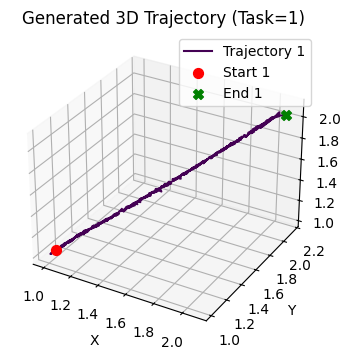

指定的起点: [1.05 1.08 1.02], 生成轨迹起点: [1.0280523 1.0443517 1.0535975], 起点欧式距离误差: 0.0537
指定的终点: [2.   2.03 2.09], 生成轨迹终点: [2.0850532 2.1368191 2.034416 ], 终点欧式误差: 0.1474


In [15]:
# model = CVAE()
# model.load_state_dict(torch.load('best_model_3D.pt'))
model.eval()
with torch.no_grad():
    test_task = 1
    start_point = np.array([1.05, 1.08, 1.02], dtype=np.float32)
    end_point = np.array([2.00, 2.03, 2.09], dtype=np.float32)
    start_point_tensor = torch.tensor([start_point], dtype=torch.float32)
    end_point_tensor = torch.tensor([end_point], dtype=torch.float32)
    test_cond = torch.tensor([test_task], dtype=torch.long)
    z_sample = torch.randn(1, 64)
    generated_trajectory = model.decoder(z_sample, test_cond, start_point_tensor, end_point_tensor, seq_len=500)

visualize_trajectories(generated_trajectory.squeeze(0).cpu().numpy(), title=f"Generated 3D Trajectory (Task={test_task})")

gen_start = generated_trajectory[:,0,:]
gen_end = generated_trajectory[:,-1,:]

error_start = torch.norm(gen_start - start_point_tensor)
error_end = torch.norm(gen_end - end_point_tensor)

print(f"now: {start_point}, goal: {gen_start.squeeze(0).cpu().numpy()}, err: {error_start.item():.4f}")
print(f"start: {end_point}, end: {gen_end.squeeze(0).cpu().numpy()}, err: {error_end.item():.4f}")